In [1]:
from jax import numpy as jnp, random, vmap, jit, value_and_grad
import qujax
import matplotlib.pyplot as plt

# Depolarising noise channel

Suppose we wish to apply a $k$-qubit unitary matrix (gate) $U$ but our system is affected by a depolarising noise channel. In density matrix notation the noiseless application of the unitary $\rho \to U\rho U^\dagger$ is replaced with

\begin{equation}
\mathcal{D}_{\bar{p},U}[\rho] = p_0 U\rho U^\dagger + \sum_{i=1}^{4^k} p_i P_i \rho P_i^\dagger, \label{dnc}\tag{1}
\end{equation}
where $P_i \in \{I, X, Y, Z\}^{\otimes k}$ and $\sum_{i=0}^{4^k} p_i = 1$.

Here we will assume single qubit gates are noiseless and two qubit gates are affected by a depolarising noise channel with shared but unknown probability vector $p$ which we will look to recover.

First let's construct the set of two qubit Pauli combinations $\{I, X, Y, Z\}^{\otimes 2}$

In [2]:
paulis = {'I': qujax.gates.I, 'X': qujax.gates.X, 'Y': qujax.gates.Y, 'Z': qujax.gates.Z}
paulis

{'I': Array([[1., 0.],
        [0., 1.]], dtype=float32),
 'X': Array([[0., 1.],
        [1., 0.]], dtype=float32),
 'Y': Array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]], dtype=complex64),
 'Z': Array([[ 1.,  0.],
        [ 0., -1.]], dtype=float32)}

In [3]:
two_paulis_strs = [a+b for a in paulis.keys() for b in paulis.keys()]
print(two_paulis_strs)

['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']


In [4]:
two_paulis_matrices = jnp.array([jnp.kron(paulis[a], paulis[b]) for a, b in two_paulis_strs])
two_paulis_matrices.shape

(16, 4, 4)

Remember we'll need to reshape them into tensor form for `qujax`

In [5]:
two_paulis_tensors = jnp.array([mat.reshape((2,) * 4) for mat in two_paulis_matrices])
two_paulis_tensors.shape

(16, 2, 2, 2, 2)

Now let's build a function that converts a two qubit unitary into one suffering from depolarising noise

In [6]:
def depolarise_arr(arr):
    return lambda p: jnp.sqrt(p) * arr

In [7]:
def depolarise(unitary_tensor):
    unitary_and_two_paulis_tensors = [unitary_tensor] + list(two_paulis_tensors)
    return [depolarise_arr(arr) for arr in unitary_and_two_paulis_tensors]

This generates a list of functions. Each function takes as input a single probability $p_i$ and outputs one of the $4^2 + 1 = 17$ Kraus operators in ([1](#mjx-eqn-dnc)) scaled by $\sqrt{p_i}$.

This function can then be accepted by `qujax`'s densitytensor simulator.

# Circuit!

Now let's define a circuit for our experiments. The circuit will then be used to generate noisy measurements based on some true underlying probability vector $p$ which we will look to recover.

In [8]:
noiseless_gate_seq = ['H', 'CX', 'CX', 'CX']
noiseless_qubit_seq = [[0], [0, 1], [1, 2], [2, 3]]
noiseless_param_ind_seq = [None] * len(noiseless_qubit_seq)

In [9]:
qujax.print_circuit(noiseless_gate_seq, noiseless_qubit_seq, noiseless_param_ind_seq);

q0: -----H-------◯-------------------
                 |                   
q1: -------------CX------◯-----------
                         |           
q2: ---------------------CX------◯---
                                 |   
q3: -----------------------------CX--


Now let's apply the depolarising noise channel to our two qubit gates

In [10]:
noisy_gate_seq = [depolarise(getattr(qujax.gates, noiseless_gate_seq[i])) if len(noiseless_qubit_seq[i]) == 2
                  else noiseless_gate_seq[i]
                  for i in range(len(noiseless_gate_seq))]

noisy_qubit_seq = noiseless_qubit_seq.copy()

p_inds = [[i] for i in range(len(two_paulis_tensors) + 1)]

noisy_param_ind_seq = [p_inds if len(noiseless_qubit_seq[i]) == 2
                       else None
                       for i in range(len(noiseless_gate_seq))]

In [11]:
qujax.print_circuit(noisy_gate_seq, noisy_qubit_seq, noisy_param_ind_seq);

q0: -----H-------◯-------------------
                 |                   
q1: -----------Kr[.]-----◯-----------
                         |           
q2: -------------------Kr[.]-----◯---
                                 |   
q3: ---------------------------Kr[.]-


That looks right, now the CX gates have been replaced with Kraus operators parameterised by the $p$ vector.

`qujax`'s densitytensor simulator can now convert the circuit representation and an inputted $p$ vector into a densitytensor - from which we can extract measurement probabilities.

In [12]:
pvec_to_densitytensor = qujax.get_params_to_densitytensor_func(noisy_gate_seq, noisy_qubit_seq, noisy_param_ind_seq)

In [13]:
def pvec_to_measure_probs(pvec):
    dt = pvec_to_densitytensor(pvec)
    nqubits = dt.ndim // 2
    dm = dt.reshape(2 ** nqubits, 2 ** nqubits)
    return jnp.diag(dm).real

# Simulation

Now let's fix some true underlying values of the probability vector $p$ which we will look to recover statistically, we'll do this by simply sampling uniformly on the simplex.

In [14]:
kraus_strs = ['U'] + two_paulis_strs

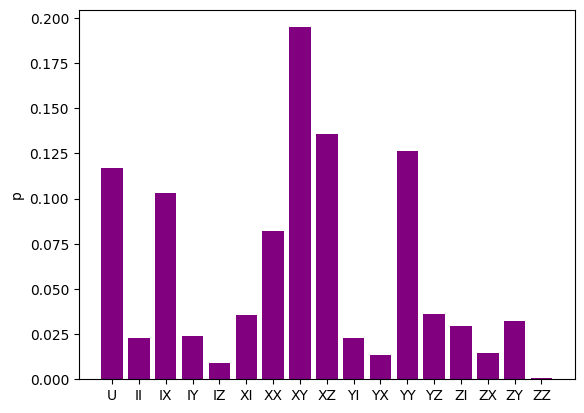

In [15]:
true_pvec = random.dirichlet(random.PRNGKey(0), jnp.ones(len(two_paulis_tensors) + 1))

plt.bar(kraus_strs, true_pvec, color='purple')
plt.ylabel('p');

Now let's sample some measurements from the true $p$

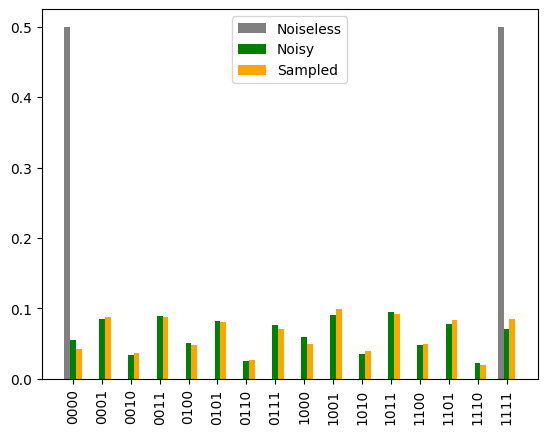

In [16]:
n_measurements = 1000

noiseless_measure_probs = pvec_to_measure_probs(jnp.zeros(17).at[0].set(1))
noisy_measure_probs = pvec_to_measure_probs(true_pvec)
measurements = random.choice(random.PRNGKey(1), len(noiseless_measure_probs), shape=(n_measurements,), p=noisy_measure_probs)

_x = jnp.arange(noiseless_measure_probs.size)
bar_width = 0.2
plt.bar(_x - 0.2, noiseless_measure_probs, bar_width, label='Noiseless', color='grey')
plt.bar(_x, noisy_measure_probs, bar_width, label='Noisy', color='green')
plt.bar(_x + 0.2, jnp.bincount(measurements) / n_measurements, bar_width, label='Sampled', color='orange')
plt.xticks(_x, [f"{a:04b}" for a in _x], rotation=90)
plt.legend();

# Inference - maximum likelihood

Now we'll forget that we know the true underlying $p$ and use statistical inference techniques to infer it.

The likelihood function is $P(\{m_j\}_{j=1}^N \mid p) = \prod_{j=1}^N P(m_j \mid p)$. Maximising the likelihood function in $p$ will give us the most probable value of $p$ that generated the measurements $\{m_j\}_{j=1}^N$.

To avoid numerical underflow we can maximise the log-likelihood rather than the likelihood itself.

In [17]:
def log_likelihood(p):
    measure_probs = pvec_to_measure_probs(p)
    return jnp.log(measure_probs)[measurements].sum()

In order to ensure the simplex constraints $0 \leq p_i \leq 1, \sum_{i=1}^{17} p_i = 1$ we can use the [stick-breaking transformation](https://mc-stan.org/docs/reference-manual/simplex-transform.html)

In [18]:
def logit(u):
    return jnp.log(u) - jnp.log(1 - u)

def inverse_logit(v):
    return 1 / (1 + jnp.exp(-v))

def constrain_simplex(y):
    k = y.shape[-1] + 1
    z = inverse_logit(y - jnp.log(k - jnp.arange(1, k)))
    z1m_cumprod = jnp.append(1., (1 - z[:-1]).cumprod())
    return z * z1m_cumprod

def unconstrain_simplex(x):
    k = x.shape[-1] + 1
    z = x / (1 - jnp.append(0, x[:-1].cumsum()))
    return logit(z) + jnp.log(k - jnp.arange(1, k))

In [19]:
def transformed_log_likelihood(z):
    pvec_trunc = constrain_simplex(z)
    pvec = jnp.append(pvec_trunc, 1-pvec_trunc.sum())
    return log_likelihood(pvec)

In [20]:
transformed_log_likelihood_and_grad = jit(value_and_grad(transformed_log_likelihood))

JAX's automatic differentiation allows us to run gradient ascent seemlessly in order to fit a maximum likelihood estimator of $p$ that maximises $\log P(\{m_j\}_{j=1}^N \mid p)$

In [21]:
stepsize = 1e-3
n_steps = 1000

tp_train = jnp.ones(16) / 17
logliks_train = jnp.zeros(n_steps)
for i in range(n_steps):
    loglik, tloglik_grad = transformed_log_likelihood_and_grad(tp_train)
    logliks_train = logliks_train.at[i].set(loglik)
    print('Step:', i+1, '\t Log-likelihood', loglik, end='\r')
    
    tp_train += stepsize * tloglik_grad

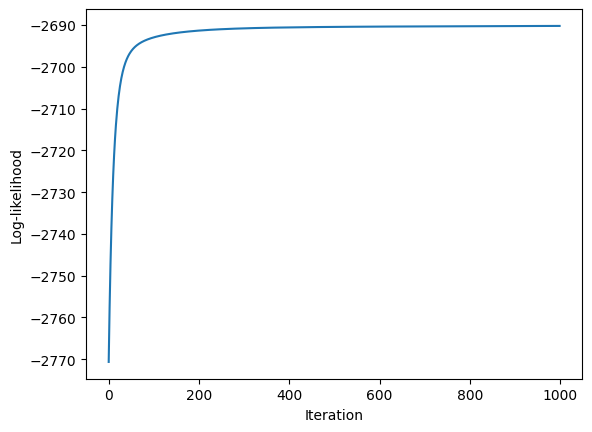

In [22]:
plt.plot(logliks_train)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood');

Looks like it trained well!

Let's examine the fitted maximum likelihood estimator of $p$

In [23]:
mle_pvec = constrain_simplex(tp_train)
mle_pvec = jnp.append(mle_pvec, 1-mle_pvec.sum())

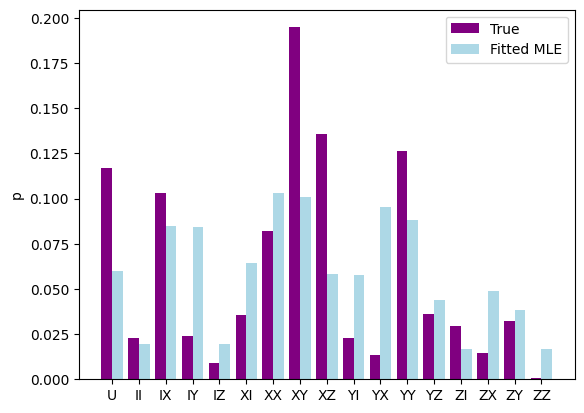

In [24]:
_x2 = jnp.arange(len(kraus_strs))
bar_width2 = 0.4
plt.bar(_x2 - 0.2, true_pvec, bar_width2, label='True', color='purple')
plt.bar(_x2 + 0.2, mle_pvec, bar_width2, label='Fitted MLE', color='lightblue')
plt.xticks(_x2, kraus_strs)
plt.ylabel('p')
plt.legend();

Ok it appears somewhat similar to the true underlying value of $p$ although there are some clear differences.

Let's also check out the measurement probabilities of the fitted MLE

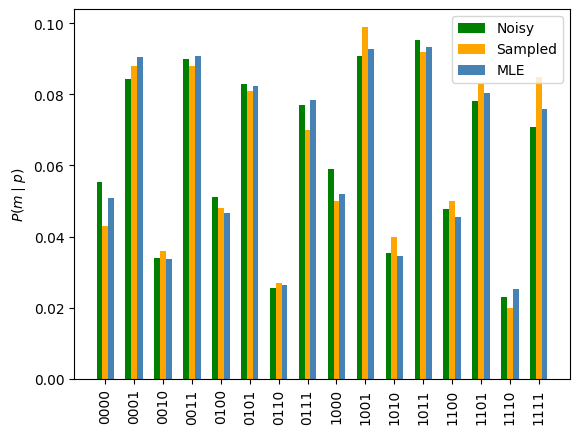

In [25]:
mle_measure_probs = pvec_to_measure_probs(mle_pvec)

plt.bar(_x - 0.2, noisy_measure_probs, bar_width, label='Noisy', color='green')
plt.bar(_x, jnp.bincount(measurements) / n_measurements, bar_width, label='Sampled', color='orange')
plt.bar(_x + 0.2, mle_measure_probs, bar_width, label='MLE', color='steelblue')
plt.xticks(_x, [f"{a:04b}" for a in _x], rotation=90)
plt.ylabel(r'$P(m \mid p)$')
plt.legend();

Very similar to both the measurement probabilities of the true $p$ as well as the measurements. This indicates that the true $p$ is not fully identifiable from our combination of circuit and measurements.

A Bayesian approach could be applied to fully quantify this uncertainty via the posterior distribution $P(p \mid \{m_j\}_{j=1}^N)$.

We could also consider more sophisticated circuits in order to generate measurements that are more informative for $p$.